In [1]:
import numpy as np
import scipy.stats as stats
import nibabel.freesurfer.mghformat as mgh
import h5py

import sys

sys.path.append("..")

from paths import *
from constants import *

sys.path.append(CODE_PATH)

from utils.general_utils import make_iterable

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors as mcolors

In [3]:
def reject_outliers(data, m=2.):
    d = np.abs(data - np.mean(data))
    mdev = np.mean(d)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

In [4]:
subjid = ["01","02", "03", "04", "05", "06", "07", "08"]
roi = "streams_shrink10"
hemis = ["rh"]
mapping_func = "PLS"
CV = 0
subsample = 2
FULL_ROI_NAMES = ['Early',
             'Midventral',
             'Midlateral',
             'Midparietal',
             'Ventral',
             'Lateral',
             'Parietal']
ROI_NAMES = ['Ventral',
             'Lateral',
             'Parietal']

source_roi = "streams"
#num_splits = 10
n_source_voxels =[0, 2, 1, 5, 10000, 6, 20000, 99, 4]
#[1000, 5000, 10000, 15000, 20000] #, 1, 99, 2, 3, 4, 5, 6]

In [5]:
means_s2s = np.empty((len(subjid), len(ROI_NAMES), len(n_source_voxels)))
all_s2s_rs = [[[[] for n in range(len(n_source_voxels))] for j in range(len(FULL_ROI_NAMES))] for i in range(len(subjid))]


for sidx, sid in enumerate(subjid):
    
    for nidx, n in enumerate(n_source_voxels):
    
        temp_s2s = {}
        num_vox = np.zeros((len(hemis)))
    
        for hidx, hemi in enumerate(hemis):
            # Get ROI data
            mgh_file = mgh.load(
                NSDDATA_PATH
                + "freesurfer/subj"
                + sid
                + "/label/"
                + hemi
                + "."
                + roi
                + ".mgz"
            )
            streams = mgh_file.get_fdata()[:, 0, 0]
            num_vox[hidx] = streams[streams != 0].shape[0]
            if hidx > 0:
                streams_trim = np.append(streams_trim, streams[streams != 0])
            else:
                streams_trim = streams[streams != 0]
            
            num_splits = 10    
            if n == 20000 or n == 1:
                num_splits = 5
                
            if n == 1:
                load_path = (RESULTS_PATH
                        + "fits/subj2subj/subj"
                        + sid
                        + "_"
                        + hemi
                        + "_"
                        + source_roi
                        + "_to_"
                        + roi
                        + "_"
                        + str(num_splits)
                        + "splits_"
                        + "_subsample_10000voxels.hdf5")
            elif n == 0:
                load_path = (RESULTS_PATH
                        + "fits/subj2subj/subj"
                        + sid
                        + "_"
                        + hemi
                        + "_"
                        + roi
                        + "_to_"
                        + roi
                        + "_"
                        + str(num_splits)
                        + "splits_"
                        + "_subsample_0voxels_subsamptype1_pooled0.hdf5")    
            elif n == 99:
                load_path = (RESULTS_PATH
                        + "fits/subj2subj/subj"
                        + sid
                        + "_"
                        + hemi
                        + "_"
                        + roi
                        + "_to_"
                        + roi
                        + "_1CV_"
                        + str(num_splits)
                        + "splits_"
                        + "_subsample_20000voxels_subsamptype1_pooled1.hdf5")    
            elif n == 2:
                load_path = (RESULTS_PATH
                        + "fits/subj2subj/subj"
                        + sid
                        + "_"
                        + hemi
                        + "_streams_shrink10_to_"
                        + roi
                        + "_Ridge_1CV_10splits__subsample_0voxels_subsamptype0_pooled0.hdf5")
            elif n == 3:
                load_path = (RESULTS_PATH
                        + "fits/subj2subj/subj"
                        + sid
                        + "_"
                        + hemi
                        + "_streams_shrink10_to_"
                        + roi
                        + "_Ridge_1CV_10splits__subsample_20000voxels_subsamptype0_pooled1.hdf5")
            elif n == 4:
                load_path = (RESULTS_PATH
                        + "fits/subj2subj/subj"
                        + sid
                        + "_"
                        + hemi
                        + "_streams_shrink10_to_"
                        + roi
                        + "_Ridge_1CV_10splits__subsample_20000voxels_subsamptype1_pooled1.hdf5")
            elif n == 5:
                load_path = (RESULTS_PATH
                        + "fits/subj2subj/subj"
                        + sid
                        + "_"
                        + hemi
                        + "_streams_shrink10_to_"
                        + roi
                        + "_Ridge_1CV_10splits__subsample_10000voxels_subsamptype0_pooled1.hdf5")
            elif n == 6:
                load_path = (RESULTS_PATH
                        + "fits/subj2subj/subj"
                        + sid
                        + "_"
                        + hemi
                        + "_streams_shrink10_to_"
                        + roi
                        + "_Ridge_1CV_10splits__subsample_10000voxels_subsamptype1_pooled1.hdf5")
            else:
                # Get subject 2 subject mapping estimates
                load_path = (RESULTS_PATH
                            + "fits/subj2subj/subj"
                            + sid
                            + "_"
                            + hemi
                            + "_"
                            + source_roi
                            + "_to_"
                            + roi
                            + "_"
                            + str(num_splits)
                            + "splits_"
                            + "_subsample_"
                            + str(n if n is not None else 0)
                            + "voxels_subsamptype1.hdf5")
            rsquared_array = {}
            with h5py.File(load_path, "r") as f:
                keys = f.keys()
                for k in keys:
                    rsquared_array[k] = f[k][:]

            for r, layer in enumerate(FULL_ROI_NAMES):        
                if hidx > 0:
                    temp_s2s[layer] = np.append(temp_s2s[layer], rsquared_array[layer])
                else:
                    temp_s2s[layer] = rsquared_array[layer]

        for r, layer in enumerate(FULL_ROI_NAMES):
            all_s2s_rs[sidx][r][nidx] = temp_s2s[layer][streams_trim==r+1]
    


In [7]:
mapping_types = [1, 0, 1, 0, 1, 0, 1, 1, 0] #0=Ridge, 1=PLS

corrected_medians = np.empty((len(subjid), len(FULL_ROI_NAMES), len(n_source_voxels)))

ridge_cmap = matplotlib.cm.get_cmap('Blues') #ridge
ridge_color_range = [.4, .7, .7, .9]
r_idx = 0
    
pls_cmap = matplotlib.cm.get_cmap('Reds')
pls_color_range = [.4, .7, .7, .9, .9] 
p_idx = 0

total_rgba = np.zeros((len(n_source_voxels), 4))
for nidx, n in enumerate(n_source_voxels):
    if mapping_types[nidx] == 0:
        total_rgba[nidx,:] = ridge_cmap(ridge_color_range[r_idx])
        r_idx += 1
    else:
        total_rgba[nidx,:] = pls_cmap(pls_color_range[p_idx])
        p_idx += 1

01


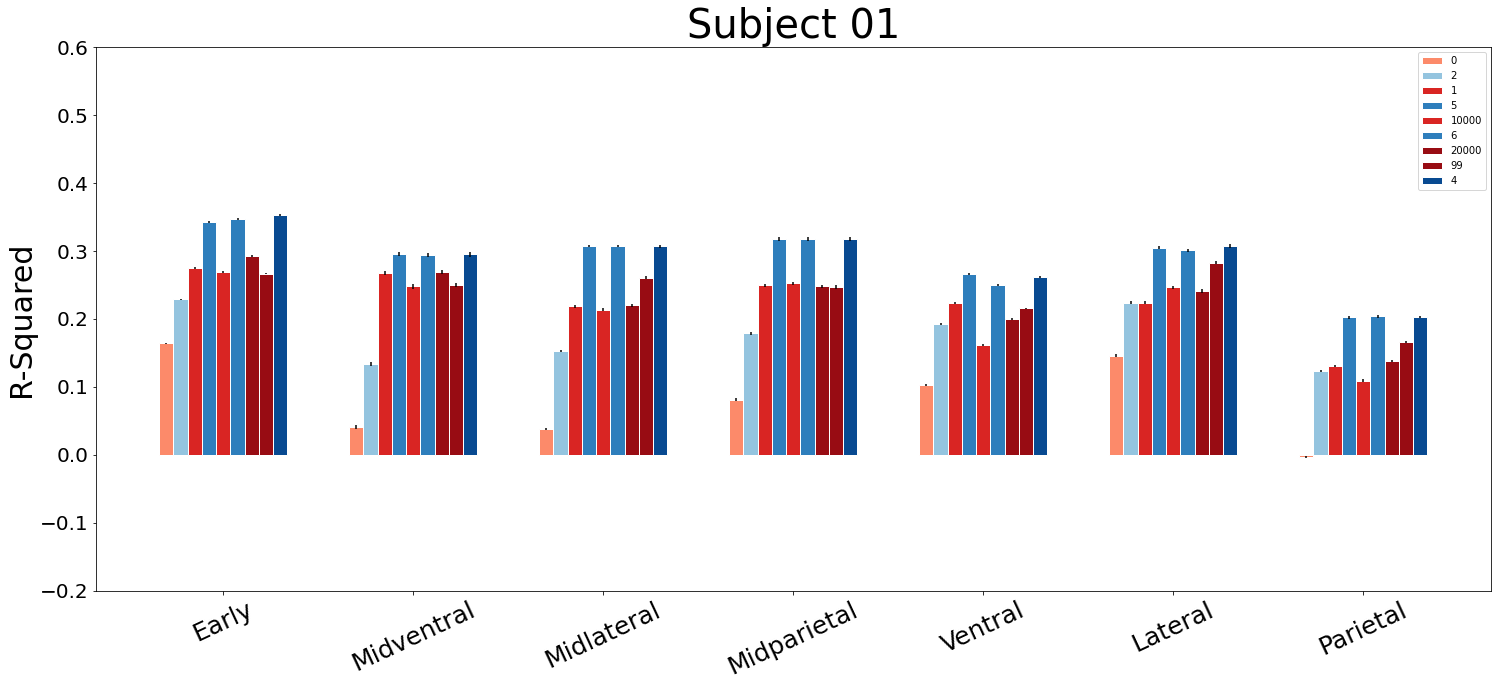

02


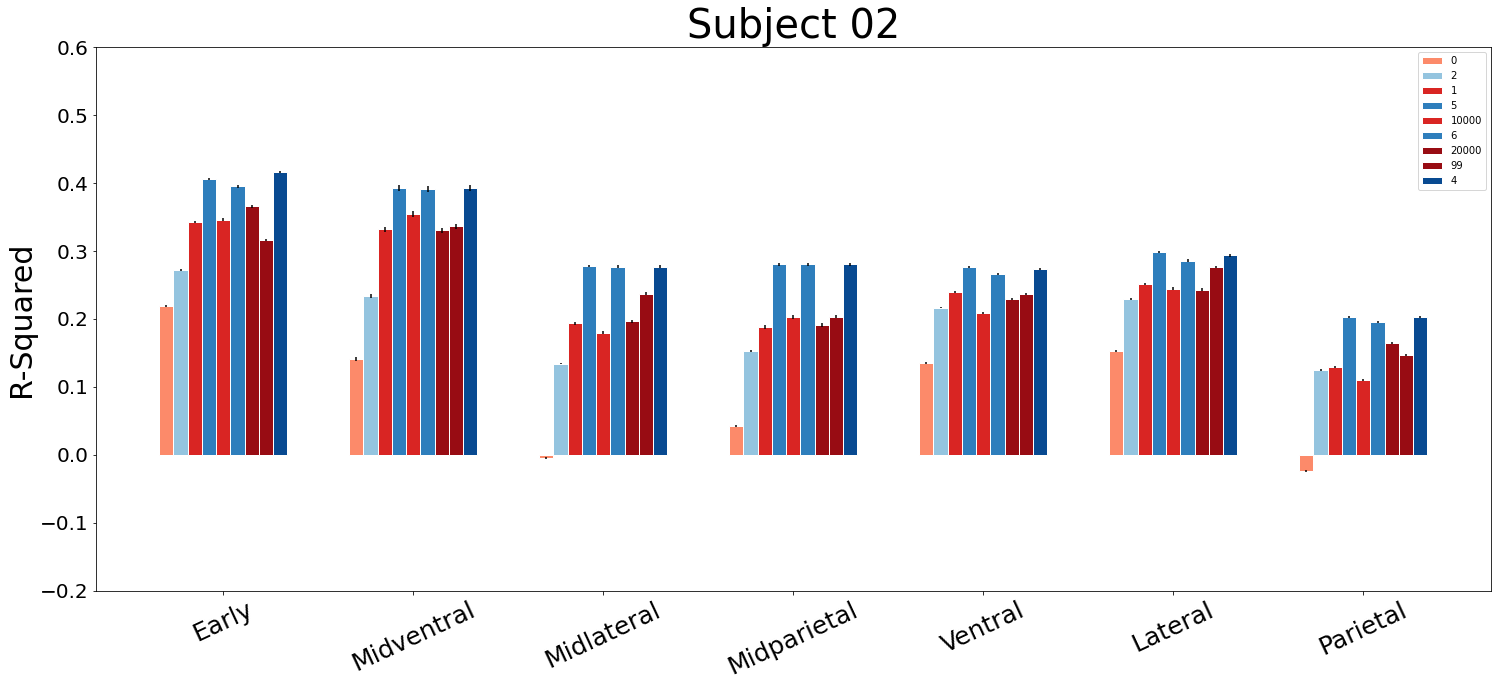

03


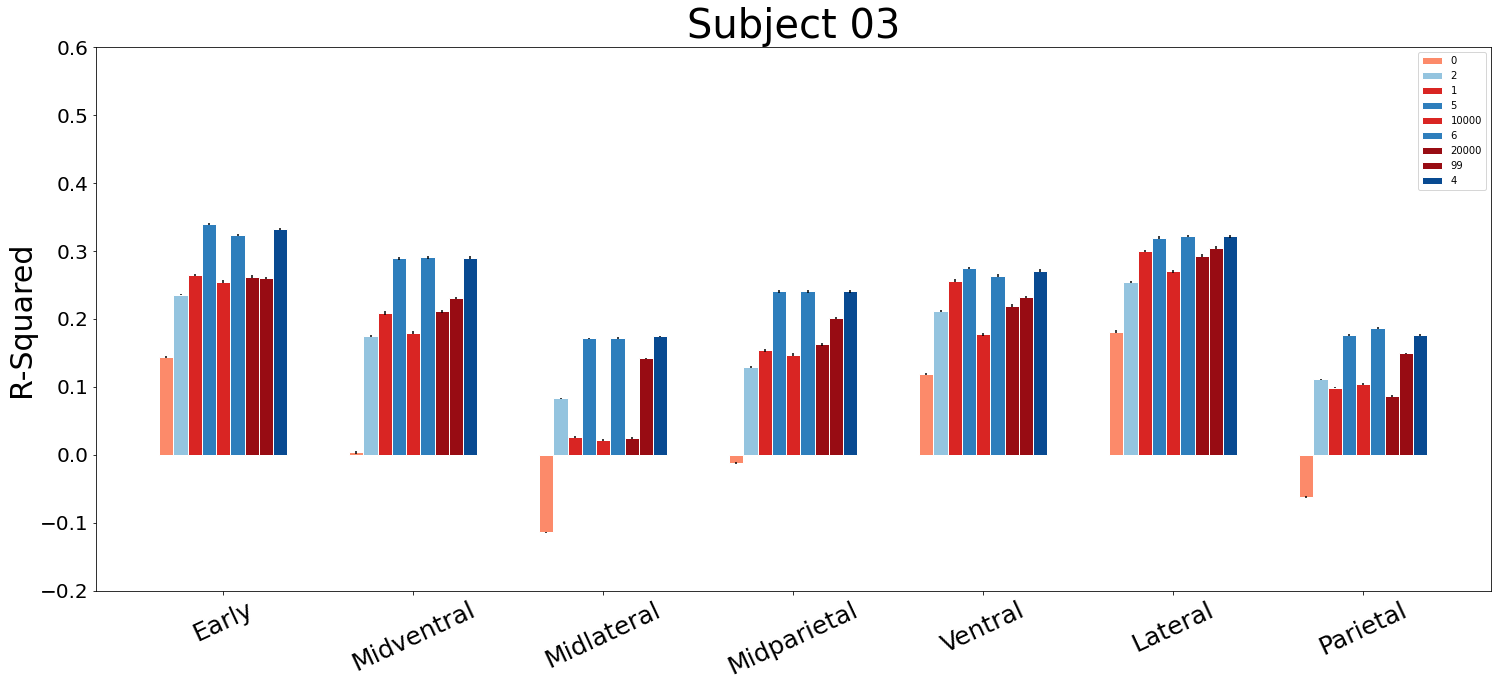

04


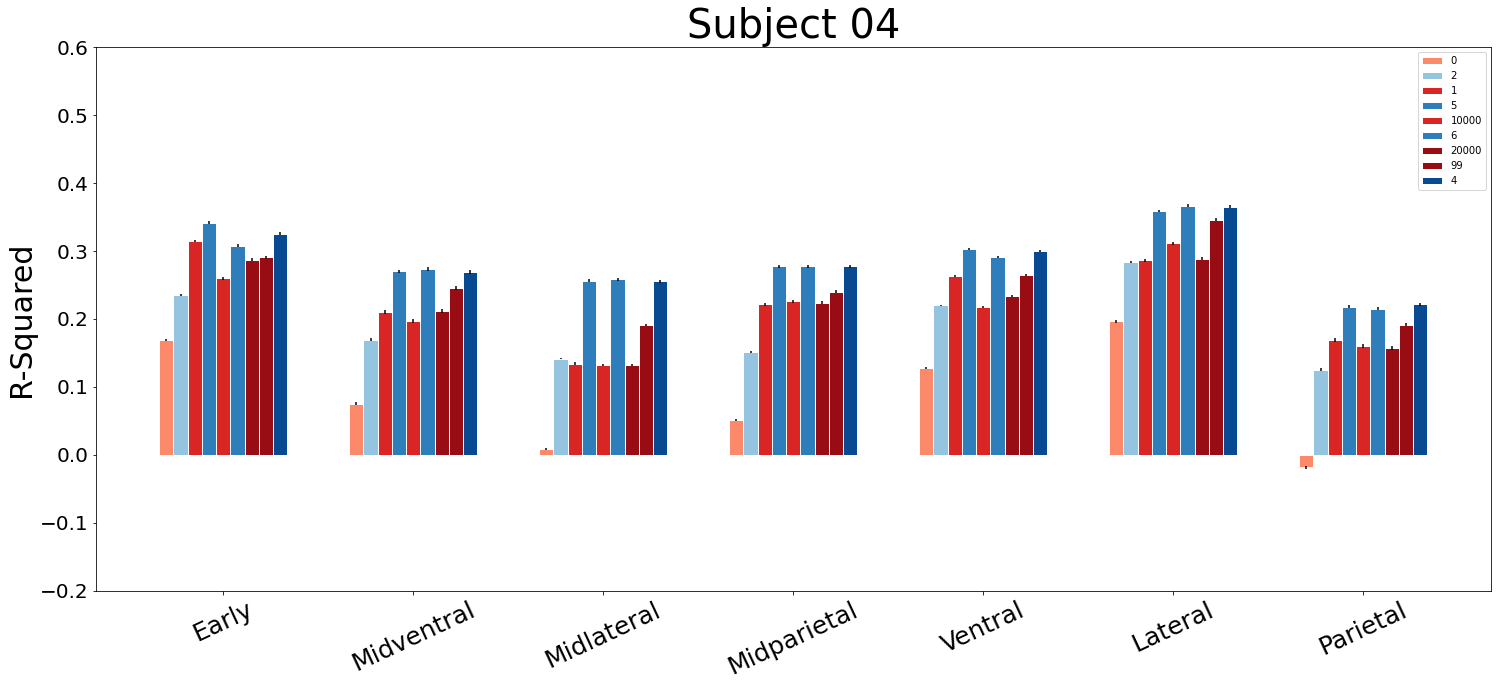

05


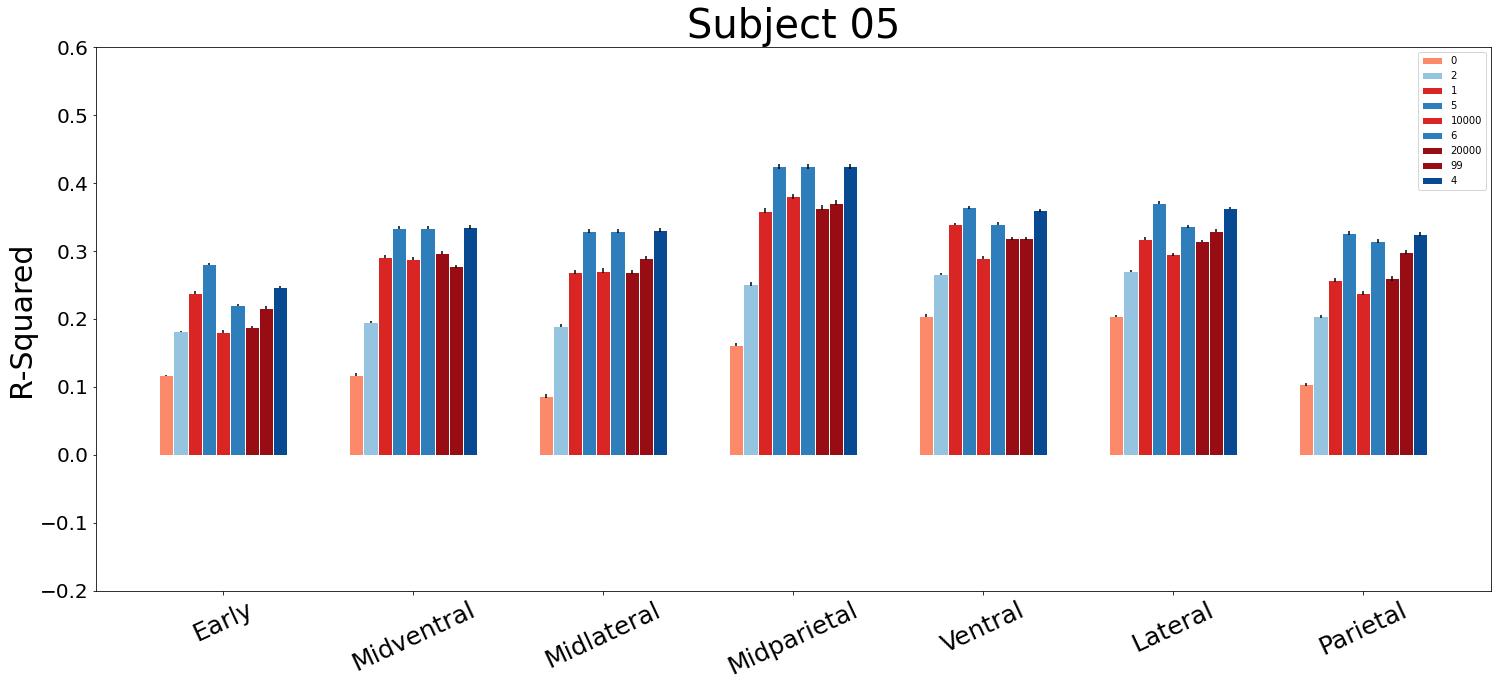

06


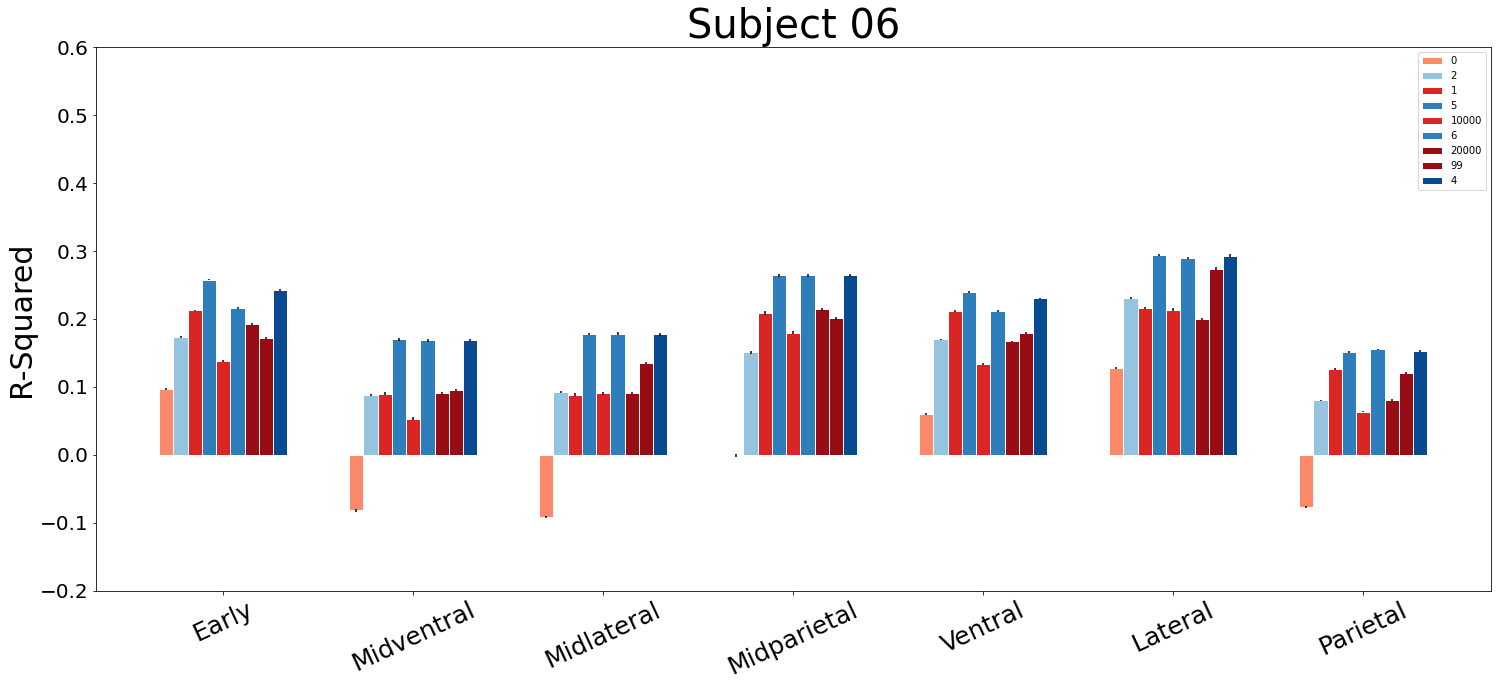

07


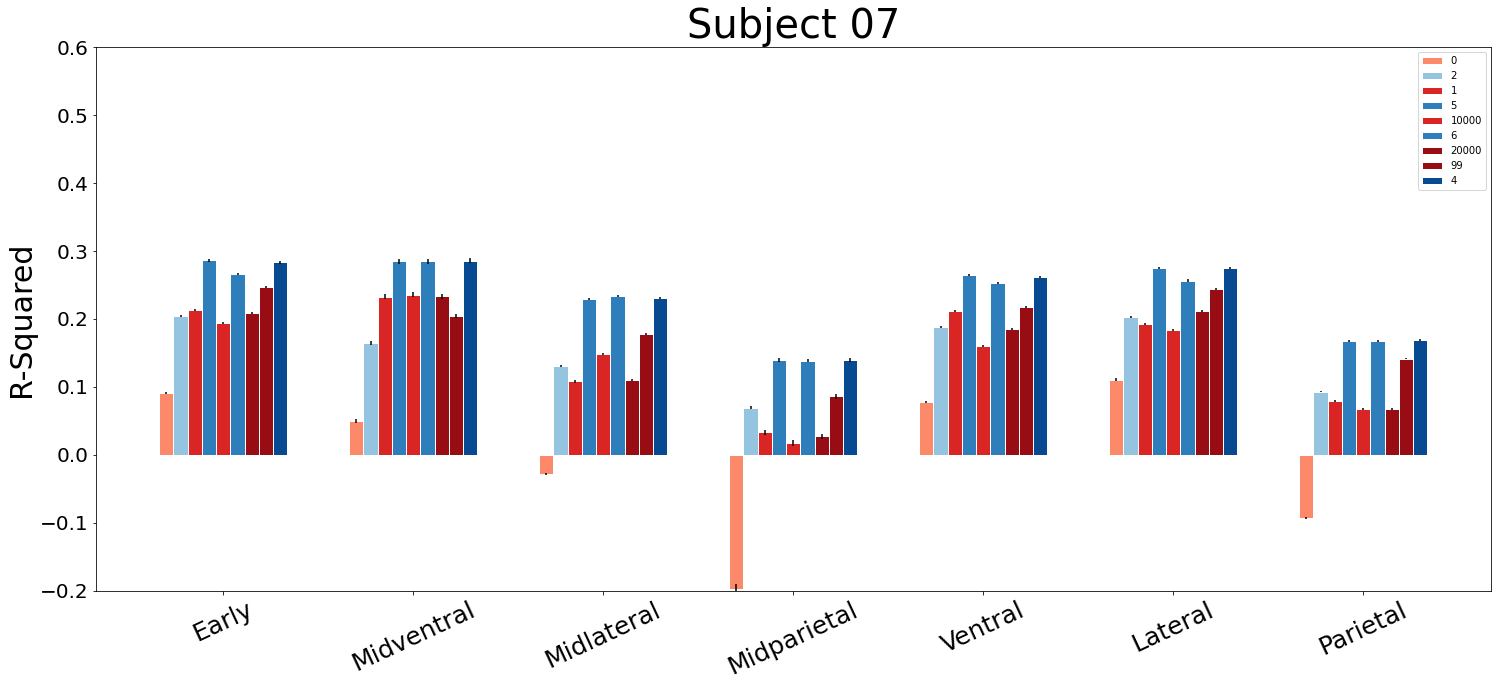

08


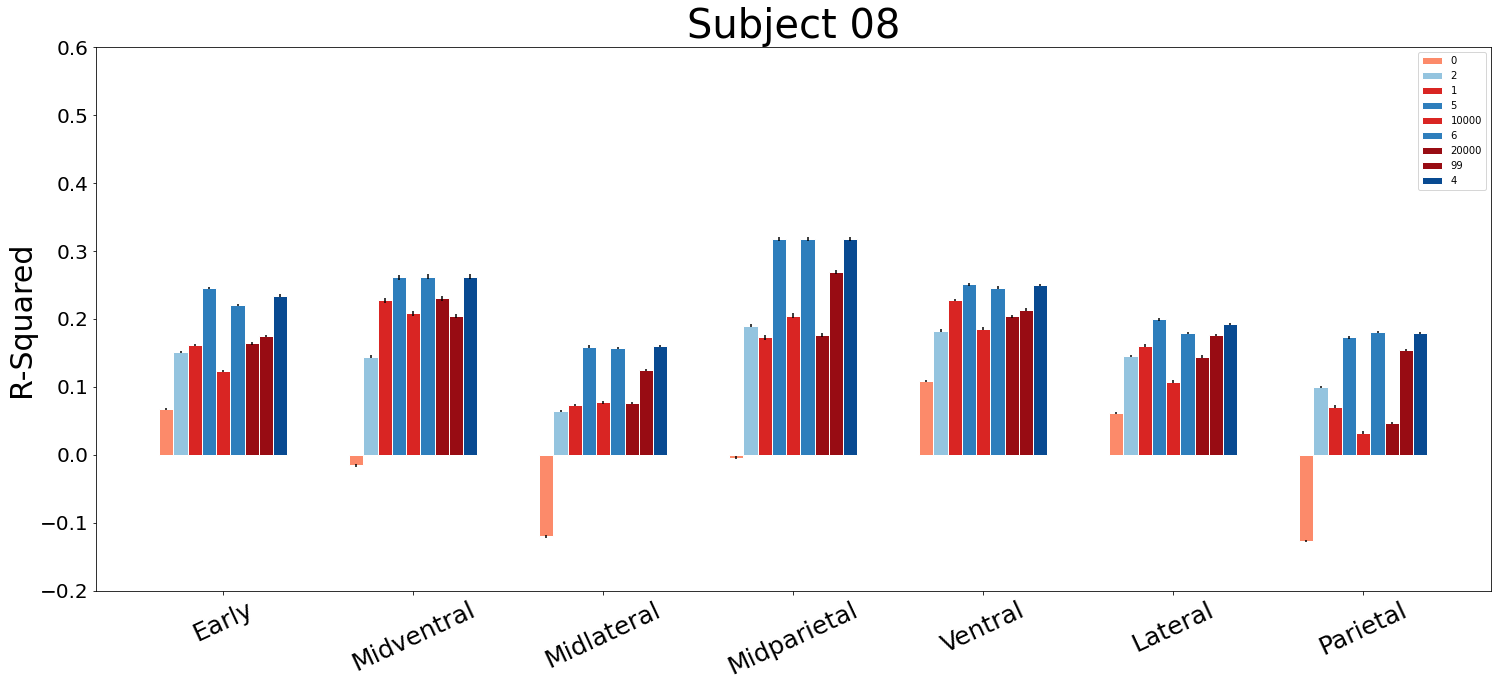

In [8]:

        
for sidx, sid in enumerate(subjid):
    print(sid)
    fig, ax = plt.subplots(figsize=(25, 10))
    fig.patch.set_facecolor('white')
    
    # set width of bars
    barWidth = 0.075
    
    for nidx, n in enumerate(n_source_voxels):
        
        for r in range(len(FULL_ROI_NAMES)):
            corrected_medians[sidx][r][nidx] = np.median(reject_outliers(all_s2s_rs[sidx][r][nidx]))
            
        data = [np.median(reject_outliers(all_s2s_rs[sidx][r][nidx])) for r in range(len(FULL_ROI_NAMES))]
        error = [stats.sem(reject_outliers(all_s2s_rs[sidx][r][nidx])) for r in range(len(FULL_ROI_NAMES))]

        # Set position of bar on X axis
        if nidx == 0:
            base = np.arange(len(data))
            r = [x - (barWidth)*(len(n_source_voxels)/2) for x in base]
        else:
            r = [x + barWidth for x in prev_r]

        # Make the plot
        plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = total_rgba[nidx], label=str(n))
        
        prev_r = r
        
    plt.axhline(y = 1, xmin = 0, xmax = 1, color = 'black', linestyle='dashed')
    plt.xticks([r - barWidth/2 for r in range(len(data))], FULL_ROI_NAMES, rotation=25, fontsize=25);

    plt.ylabel('R-Squared',size = 30)
    plt.yticks(fontsize=20)
    
    plt.ylim([-.2, .6])

    title_string = "Subject "
    title_string += sid
    plt.title(title_string,size = 40)

    # Create legend & Show graphic
    plt.legend(fontsize=10)

    plt.show()

08


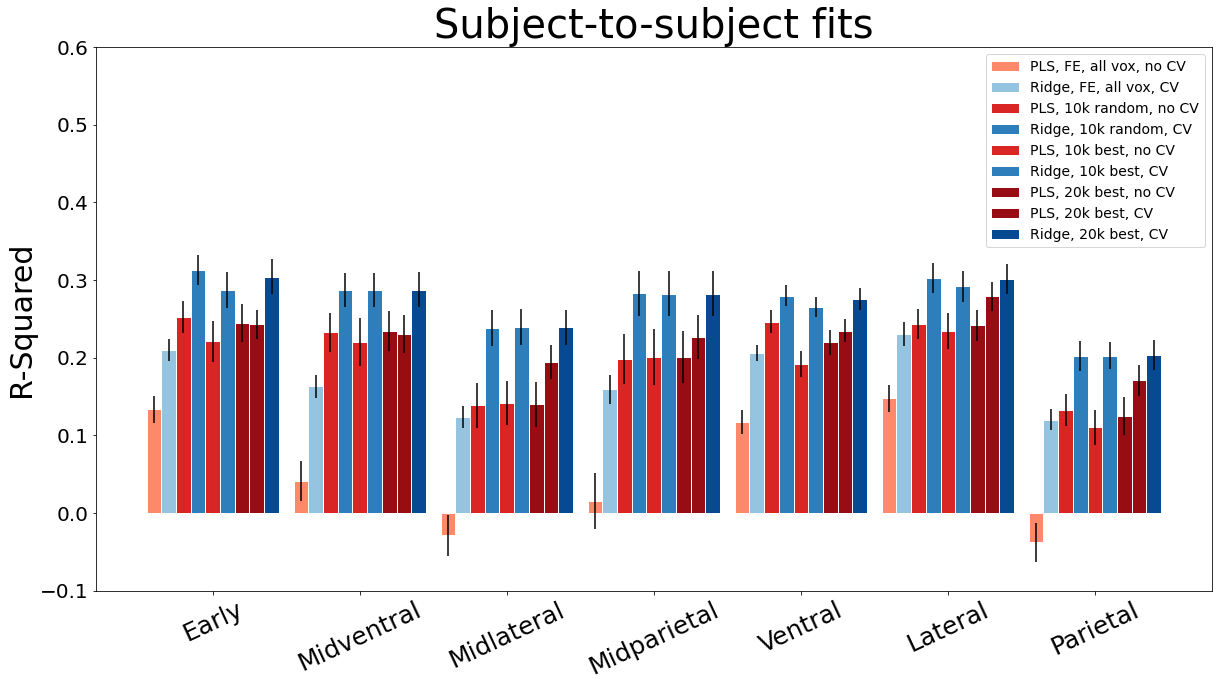

In [12]:
print(sid)
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')

# set width of bars
barWidth = 0.1

mean_corrected_medians = np.mean(corrected_medians, axis=0)
sem_corrected_medians = stats.sem(corrected_medians, axis=0)

for nidx, n in enumerate(n_source_voxels):
    
    data = [mean_corrected_medians[r][nidx] for r in range(len(FULL_ROI_NAMES))]
    error = [sem_corrected_medians[r][nidx] for r in range(len(FULL_ROI_NAMES))]

    # Set position of bar on X axis
    if nidx == 0:
        base = np.arange(len(data))
        r = [x - (barWidth)*(len(n_source_voxels)/2) for x in base]
    else:
        r = [x + barWidth for x in prev_r]

    # Make the plot
    if n == 1:
        plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = total_rgba[nidx], label="PLS, 10k random, no CV")
    elif n == 99:
        plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = total_rgba[nidx], label="PLS, 20k best, CV")
    elif n == 10000:
        plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = total_rgba[nidx], label="PLS, 10k best, no CV")
    elif n == 20000:
        plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = total_rgba[nidx], label="PLS, 20k best, no CV")
    elif n == 2:
        plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = total_rgba[nidx], label="Ridge, FE, all vox, CV")
    elif n == 0:
        plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = total_rgba[nidx], label="PLS, FE, all vox, no CV")
    elif n == 3:
        plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = total_rgba[nidx], label="Ridge, 20k random, CV")
    elif n == 4:
        plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = total_rgba[nidx], label="Ridge, 20k best, CV")
    elif n == 5:
        plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = total_rgba[nidx], label="Ridge, 10k random, CV")
    elif n == 6:
        plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = total_rgba[nidx], label="Ridge, 10k best, CV")
    else:
        plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = total_rgba[nidx], label=str(n))

    prev_r = r

plt.axhline(y = 1, xmin = 0, xmax = 1, color = 'black', linestyle='dashed')
plt.xticks([r - barWidth/2 for r in range(len(data))], FULL_ROI_NAMES, rotation=25, fontsize=25);

plt.ylabel('R-Squared',size = 30)
plt.yticks(fontsize=20)

plt.ylim([-.1, .6])

title_string = "Subject-to-subject fits"
plt.title(title_string,size = 40)

# Create legend & Show graphic
plt.legend(fontsize=14)

plt.show()

save_path = (RESULTS_PATH 
                + "fits/figures/s2s_fits_PLS_Ridge_comp_rh.png")
#
fig.savefig(save_path)